# Covid-19 Vaccine Allocations and Case Counts Analysis
----

Written in the Python 3.7.9 Environment

By Tarak Patel, Nicole Lund and Anne Niemiec.

Common Jupyter cells have been notated for ease of merging after individuals their analysis.

Individual working files will be merged using https://pypi.org/project/nbmerge/

In [70]:
# Load Dependencies

# Data Organization & Collection
import pandas as pd
import requests
import json
from census import Census

# Data Visualization & Analysis
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import scipy.stats as st
import gmaps

# General Navigation
import time
import os
import sys

In [71]:
# Load clean data for Case and Death Counts by state and time
    # This data combines:
        # United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv'
        # state_code.csv

c_d_withstate_df_path = r"..\data_manipulation\clean_data\c_d_withstate_df.csv"
cases_deaths_df = pd.read_csv(c_d_withstate_df_path)
cases_deaths_df.head(3)

,state_name,state_code,date,day_num,total_cases,confirmed_cases,probable_cases,new_cases,pnew_cases,total_deaths,confirmed_deaths,probable_deaths,new_deaths,pnew_deaths,consent_cases,consent_deaths,created_at
0,Alaska,AK,12/14/2020,0,40160,0.0,0.0,422,0.0,175,0.0,0.0,0,0.0,0,0,12/15/2020 14:39
1,Alabama,AL,12/14/2020,0,297895,244762.0,53133.0,2264,332.0,4102,3624.0,478.0,0,0.0,Agree,Agree,12/15/2020 14:39
2,Arkansas,AR,12/14/2020,0,187057,0.0,0.0,1355,122.0,2990,0.0,0.0,45,22.0,Not agree,Not agree,12/15/2020 14:39


In [72]:
# Load clean data for Vaccination Allocation Data by state and time
    # This data combines:
        # COVID-19_Vaccine_Distribution_Allocations_by_Jurisdiction_-_Pfizer.csv
        # COVID-19_Vaccine_Distribution_Allocations_by_Jurisdiction_-_Moderna.csv
        # COVID-19_Vaccine_Distribution_Allocations_by_Jurisdiction_-_Janssen.csv

Combined_Vaccine_df_path = r"..\data_manipulation\clean_data\Combined_Vaccine_df.csv"
vaccine_allocation_df = pd.read_csv(Combined_Vaccine_df_path)
vaccine_allocation_df.head(3)

,state_name,state_code,date,day_num,pfe_dose_1,pfe_dose_2,mrna_dose_1,mrna_dose_2,jnj_dose_1
0,Connecticut,CT,04/19/2021,126,54990,54990,40400.0,40400.0,0.0
1,Maine,ME,04/19/2021,126,21060,21060,15400.0,15400.0,0.0
2,Massachusetts,MA,04/19/2021,126,105300,105300,77700.0,77700.0,0.0


In [73]:
# Load clean data for State Population from Census reports
    # This data collects census API request data by state:
        # Population.csv

Population_path = r"..\data_manipulation\clean_data\Population.csv"
census_df = pd.read_csv(Population_path)
census_df.head(3)

,state_name,state_code,population,median_age,household_income,per_capita_income,poverty_count,poverty_rate,unemployment_count,unemployment_rate
0,Alabama,AL,4876250.0,39.0,50536.0,27928.0,795989.0,16.323794,132095.0,2.708946
1,Alaska,AK,737068.0,34.3,77640.0,36787.0,76933.0,10.437707,26808.0,3.637114
2,Arizona,AZ,7050299.0,37.7,58945.0,30694.0,1043764.0,14.804535,195905.0,2.778676


In [74]:
# Load clean data for Daily Vaccination Administered Data by state
     
Vaccine_admin_path = r"..\data_manipulation\clean_data\Vaccines_Administered_df.csv"
vaccine_admin_df = pd.read_csv(Vaccine_admin_path)
vaccine_admin_df.head(3)

,state_name,state_code,date,day_num,daily_vaccinations
0,Alabama,AL,1/13/2021,30,5906
1,Alabama,AL,1/14/2021,31,7083
2,Alabama,AL,1/15/2021,32,7478


# Group 1 Analysis - by Tarak Patel

## Line Plot showing National Summarized Vaccine Allocations by Date 
x-axis = Date (The data is reported weekly. To simplify the labels, convert the dates to a week number and then label by month.)

y-axis =

Line 1 - Pfizer + Moderna 1st dose allocation  
Line 2 - Pfizer + Moderna 2nd dose allocation  
Line 3 - J&J allocations  
Note: y-axis data is a summation for all states  
Legend labels = Pfizer + Moderna 1st dose, Pfizer + Moderna 2nd dose, J&J Single dose

In [75]:
vaccine_allocation_df['Month'] = pd.DatetimeIndex(vaccine_allocation_df['date']).month.astype(str)
vaccine_allocation_df['Year'] = pd.DatetimeIndex(vaccine_allocation_df['date']).year.astype(str)
vaccine_allocation_df['yr_mo'] = vaccine_allocation_df['Year'] + '-' + vaccine_allocation_df['Month']
vaccine_By_day = vaccine_allocation_df.groupby(['day_num', 'date', 'yr_mo']).sum().reset_index()
vaccine_By_day.head(3)
# vaccine_allocation_df.head(3)

,day_num,date,yr_mo,pfe_dose_1,pfe_dose_2,mrna_dose_1,mrna_dose_2,jnj_dose_1
0,0,12/14/2020,2020-12,2980575,2943525,0.0,0.0,0.0
1,7,12/21/2020,2020-12,2071875,2071875,5990000.0,5948600.0,0.0
2,14,12/28/2020,2020-12,2643225,2643225,2047300.0,2047300.0,0.0


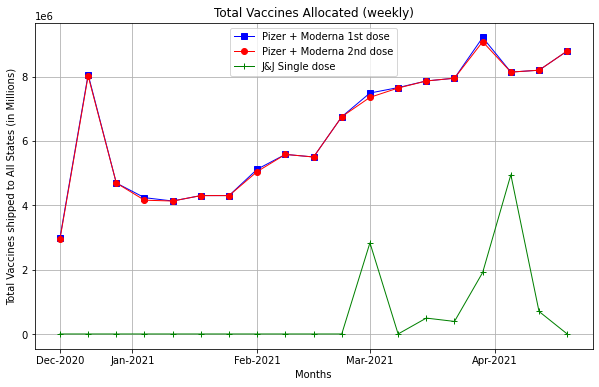

In [76]:
## Adding Dose 1 PFE and MRNA And Adding Dose2 PFE and MRNA
vaccine_By_day['Dose_1'] = vaccine_By_day['pfe_dose_1'] + vaccine_By_day['mrna_dose_1']
vaccine_By_day['Dose_2'] = vaccine_By_day['pfe_dose_2'] + vaccine_By_day['mrna_dose_2']

## Plot Figure
plt.figure(figsize=(10,6))
plt.plot(vaccine_By_day['day_num'], vaccine_By_day['Dose_1'], marker='s',color='b', linewidth=1, label='Pizer + Moderna 1st dose')
plt.plot(vaccine_By_day['day_num'], vaccine_By_day['Dose_2'], marker='o', color='red', linewidth=1, label='Pizer + Moderna 2nd dose')
plt.plot(vaccine_By_day['day_num'], vaccine_By_day['jnj_dose_1'], marker='+', color='green', linewidth=1, label='J&J Single dose')

## Labels and Ticks
plt.xlabel('Months')
plt.ylabel('Total Vaccines shipped to All States (in Millions)')
plt.title('Total Vaccines Allocated (weekly)')
plt.xticks([0, 18, 49, 77, 108], ['Dec-2020', 'Jan-2021', 'Feb-2021', 'Mar-2021', 'Apr-2021'], rotation='horizontal')
plt.legend(loc='upper center')
plt.grid()

plt.savefig('Graphs/Line_Vaccine_allocation_by_date.png')
plt.show()

# vaccine_By_day.to_csv('vacation.csv')

## Line Plot showing National Vaccine Allocations by Date
x-axis = Date (The data is reported weekly. To simplify the labels, convert the dates to a week number and then label by month.)

y-axis =

Line 1 - Pfizer 1st dose allocation  
Line 2 - Moderna 1st dose allocations  
Line 3 - Pfizer 2nd dose allocations  
Line 4 - Moderna 2nd dose allocations  
Line 5 - J&J allocations  
Note: y-axis data is a summation for all states  
Legend labels = Pfizer 1st dose, Moderna 1st dose, Pfizer 2nd dose, Moderna 2nd dose, J&J Single dose

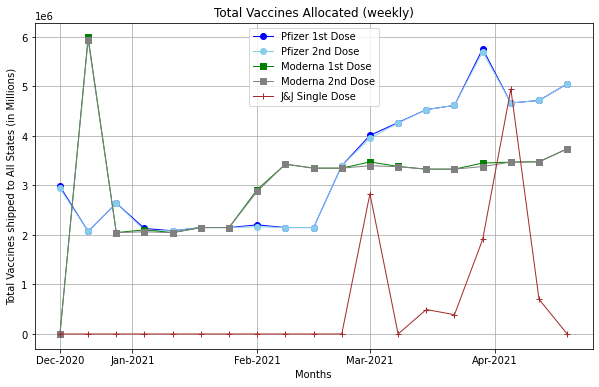

In [77]:
## Plot Figure
plt.figure(figsize=(10,6))
plt.plot(vaccine_By_day['day_num'], vaccine_By_day['pfe_dose_1'], marker='o',color='b', linewidth=1, label='Pfizer 1st Dose')
plt.plot(vaccine_By_day['day_num'], vaccine_By_day['pfe_dose_2'], marker='o', color='skyblue', linewidth=1, label='Pfizer 2nd Dose')
plt.plot(vaccine_By_day['day_num'], vaccine_By_day['mrna_dose_1'], marker='s', color='green', linewidth=1, label='Moderna 1st Dose')
plt.plot(vaccine_By_day['day_num'], vaccine_By_day['mrna_dose_2'], marker='s', color='grey', linewidth=1, label='Moderna 2nd Dose')
plt.plot(vaccine_By_day['day_num'], vaccine_By_day['jnj_dose_1'], marker='+', color='brown', linewidth=1, label='J&J Single Dose')

## Labels and Ticks
plt.xlabel('Months')
plt.ylabel('Total Vaccines shipped to All States (in Millions)')
plt.title('Total Vaccines Allocated (weekly)')
plt.xticks([0, 18, 49, 77, 108], ['Dec-2020', 'Jan-2021', 'Feb-2021', 'Mar-2021', 'Apr-2021'], rotation='horizontal')
plt.legend(loc='upper center')
plt.grid()

plt.savefig('Graphs/Line_Vaccine_allocation_all_companies.png')
plt.show()

## Line Plot showing Individual State (Arizona) Vaccine Allocations by Date
x-axis = Date (The data is reported weekly. To simplify the labels, convert the dates to a week number and then label by month.)

y-axis =

Line 1 - Pfizer 1st dose allocation  
Line 2 - Moderna 1st dose allocations  
Line 3 - Pfizer 2nd dose allocations  
Line 4 - Moderna 2nd dose allocations  
Line 5 - J&J allocations  
Legend labels = Pfizer 1st dose, Moderna 1st dose, Pfizer 2nd dose, Moderna 2nd dose, J&J Single dose

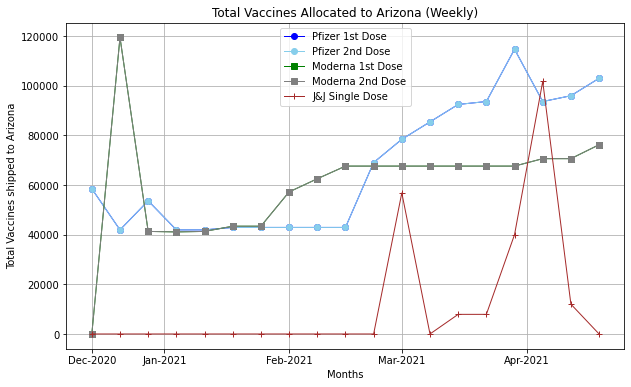

In [78]:
state_df = vaccine_allocation_df[vaccine_allocation_df['state_name'] == 'Arizona'].sort_values(by='day_num').reset_index()
state_df

## Plot Figure
plt.figure(figsize=(10,6))
plt.plot(state_df['day_num'], state_df['pfe_dose_1'], marker='o',color='b', linewidth=1, label='Pfizer 1st Dose')
plt.plot(state_df['day_num'], state_df['pfe_dose_2'], marker='o', color='skyblue', linewidth=1, label='Pfizer 2nd Dose')
plt.plot(state_df['day_num'], state_df['mrna_dose_1'], marker='s', color='green', linewidth=1, label='Moderna 1st Dose')
plt.plot(state_df['day_num'], state_df['mrna_dose_2'], marker='s', color='grey', linewidth=1, label='Moderna 2nd Dose')
plt.plot(state_df['day_num'], state_df['jnj_dose_1'], marker='+', color='brown', linewidth=1, label='J&J Single Dose')

## Labels and Ticks
plt.xlabel('Months')
plt.ylabel('Total Vaccines shipped to Arizona')
plt.title('Total Vaccines Allocated to Arizona (Weekly)')
plt.xticks([0, 18, 49, 77, 108], ['Dec-2020', 'Jan-2021', 'Feb-2021', 'Mar-2021', 'Apr-2021'], rotation='horizontal')
plt.legend(loc='upper center')
plt.grid()

plt.savefig('Graphs/Line_Vaccine_allocation_Arizona.png')
plt.show()

## Nicole Lund duplicated the Arizona chart for Alaska to understand why Alaska's data looks so different on the summary charts
## Line Plot showing Individual State (Alaska) Vaccine Allocations by Date
x-axis = Date (The data is reported weekly. To simplify the labels, convert the dates to a week number and then label by month.)

y-axis =

Line 1 - Pfizer 1st dose allocation  
Line 2 - Moderna 1st dose allocations  
Line 3 - Pfizer 2nd dose allocations  
Line 4 - Moderna 2nd dose allocations  
Line 5 - J&J allocations  
Legend labels = Pfizer 1st dose, Moderna 1st dose, Pfizer 2nd dose, Moderna 2nd dose, J&J Single dose

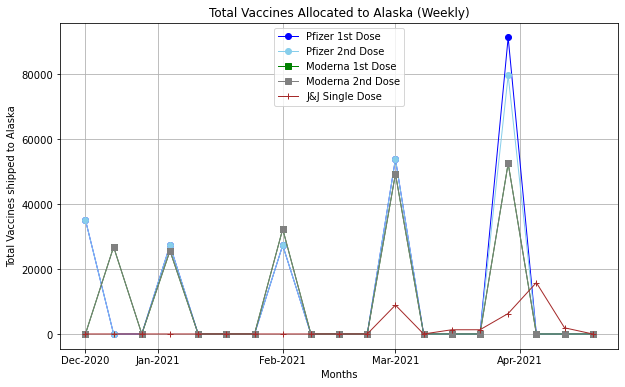

In [79]:
# Nicole Lund duplicated the Arizona chart for Alaska to understand why Alaska's data looks so different on the summary charts

state_df = vaccine_allocation_df[vaccine_allocation_df['state_name'] == 'Alaska'].sort_values(by='day_num').reset_index()
state_df

## Plot Figure
plt.figure(figsize=(10,6))
plt.plot(state_df['day_num'], state_df['pfe_dose_1'], marker='o',color='b', linewidth=1, label='Pfizer 1st Dose')
plt.plot(state_df['day_num'], state_df['pfe_dose_2'], marker='o', color='skyblue', linewidth=1, label='Pfizer 2nd Dose')
plt.plot(state_df['day_num'], state_df['mrna_dose_1'], marker='s', color='green', linewidth=1, label='Moderna 1st Dose')
plt.plot(state_df['day_num'], state_df['mrna_dose_2'], marker='s', color='grey', linewidth=1, label='Moderna 2nd Dose')
plt.plot(state_df['day_num'], state_df['jnj_dose_1'], marker='+', color='brown', linewidth=1, label='J&J Single Dose')

## Labels and Ticks
plt.xlabel('Months')
plt.ylabel('Total Vaccines shipped to Alaska')
plt.title('Total Vaccines Allocated to Alaska (Weekly)')
plt.xticks([0, 18, 49, 77, 108], ['Dec-2020', 'Jan-2021', 'Feb-2021', 'Mar-2021', 'Apr-2021'], rotation='horizontal')
plt.legend(loc='upper center')
plt.grid()

plt.savefig('Graphs/Line_Vaccine_allocation_Alaska.png')
plt.show()

## Bonus Line Plot showing Individual State (User Choice) Vaccine Allocations by Date
x-axis = Date (The data is reported weekly. To simplify the labels, convert the dates to a week number and then label by month.)

y-axis =

Line 1 - Pfizer 1st dose allocation  
Line 2 - Moderna 1st dose allocations  
Line 3 - Pfizer 2nd dose allocations  
Line 4 - Moderna 2nd dose allocations  
Line 5 - J&J allocations  
Legend labels = Pfizer 1st dose, Moderna 1st dose, Pfizer 2nd dose, Moderna 2nd dose, J&J Single dose

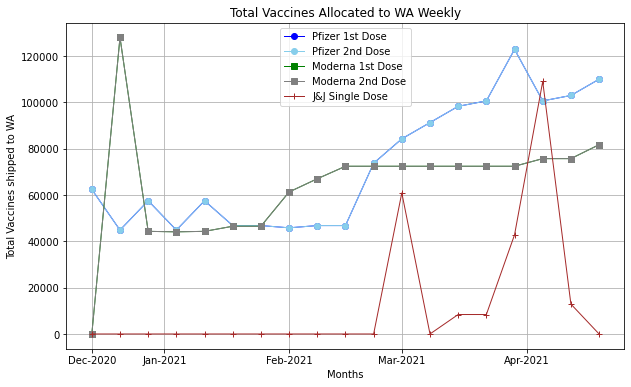

In [80]:
userchoice = input('Select State Code or State name')

state_df = vaccine_allocation_df[(vaccine_allocation_df['state_code'] == userchoice) | (vaccine_allocation_df['state_name'] == userchoice)].sort_values(by='day_num').reset_index()
state_df

## Plot Figure
plt.figure(figsize=(10,6))
plt.plot(state_df['day_num'], state_df['pfe_dose_1'], marker='o',color='b', linewidth=1, label='Pfizer 1st Dose')
plt.plot(state_df['day_num'], state_df['pfe_dose_2'], marker='o', color='skyblue', linewidth=1, label='Pfizer 2nd Dose')
plt.plot(state_df['day_num'], state_df['mrna_dose_1'], marker='s', color='green', linewidth=1, label='Moderna 1st Dose')
plt.plot(state_df['day_num'], state_df['mrna_dose_2'], marker='s', color='grey', linewidth=1, label='Moderna 2nd Dose')
plt.plot(state_df['day_num'], state_df['jnj_dose_1'], marker='+', color='brown', linewidth=1, label='J&J Single Dose')

## Labels and Ticks
plt.xlabel('Months')
plt.ylabel(f'Total Vaccines shipped to {userchoice}')
plt.title(f'Total Vaccines Allocated to {userchoice} Weekly')
plt.xticks([0, 18, 49, 77, 108], ['Dec-2020', 'Jan-2021', 'Feb-2021', 'Mar-2021', 'Apr-2021'], rotation='horizontal')
plt.legend(loc='upper center')
plt.grid()
plt.show()

## Chart showing the Total Dose Allocated Vs Total Dose Administered by State   
x-axis = State  
y-axis =   
1. Total Vaccines Allocated   
2. Total Vaccine Administered  


In [81]:
#Sum Daily Vaccine adminstered by state
vaccine_admin_state_df = vaccine_admin_df.groupby(['state_code']).sum().reset_index()

## Sum Vaccine Allocated by State
vaaccine_alloc_state_df = vaccine_allocation_df.groupby(['state_code']).sum().reset_index()
vaaccine_alloc_state_df

## Merge Vaccine Allocated and Daily Vaccine Administered DF
merge_vac_all_admin_df = pd.merge(vaccine_admin_state_df, vaaccine_alloc_state_df, on='state_code', how='inner')
merge_vac_all_admin_df

## Merge above DF with Census data 
## The reason I used this df is to keep the number of record consistant across the different columns. 
merge_alloc_admin_census_df = pd.merge(merge_vac_all_admin_df, census_df, on='state_code', how='inner')
merge_alloc_admin_census_df.head(3)

# merge_alloc_admin_census_df
# # merge_df.to_csv('merge_df.csv')

,state_code,day_num_x,daily_vaccinations,day_num_y,pfe_dose_1,pfe_dose_2,mrna_dose_1,mrna_dose_2,jnj_dose_1,state_name,population,median_age,household_income,per_capita_income,poverty_count,poverty_rate,unemployment_count,unemployment_rate
0,AK,7950,492655,1197,234780,223080,186500.0,186500.0,35500.0,Alaska,737068.0,34.3,77640.0,36787.0,76933.0,10.437707,26808.0,3.637114
1,AL,7950,2256790,1197,901680,901680,804400.0,804400.0,159900.0,Alabama,4876250.0,39.0,50536.0,27928.0,795989.0,16.323794,132095.0,2.708946
2,AR,7950,1676987,1197,551460,551460,487900.0,487900.0,97100.0,Arkansas,2999370.0,38.1,47597.0,26577.0,496260.0,16.545475,70481.0,2.349860


In [82]:
# #Sum the columns. Rember to use population1 column for pupulateion because you don't want to sum bhe Population column 
merge_alloc_admin_census_df['Total Allocated'] = merge_alloc_admin_census_df['pfe_dose_1'] + merge_alloc_admin_census_df['pfe_dose_2'] + merge_alloc_admin_census_df['mrna_dose_1'] + merge_alloc_admin_census_df['mrna_dose_2'] + merge_alloc_admin_census_df['jnj_dose_1']
merge_alloc_admin_census_df.head(3)

,state_code,day_num_x,daily_vaccinations,day_num_y,pfe_dose_1,pfe_dose_2,mrna_dose_1,mrna_dose_2,jnj_dose_1,state_name,population,median_age,household_income,per_capita_income,poverty_count,poverty_rate,unemployment_count,unemployment_rate,Total Allocated
0,AK,7950,492655,1197,234780,223080,186500.0,186500.0,35500.0,Alaska,737068.0,34.3,77640.0,36787.0,76933.0,10.437707,26808.0,3.637114,866360.0
1,AL,7950,2256790,1197,901680,901680,804400.0,804400.0,159900.0,Alabama,4876250.0,39.0,50536.0,27928.0,795989.0,16.323794,132095.0,2.708946,3572060.0
2,AR,7950,1676987,1197,551460,551460,487900.0,487900.0,97100.0,Arkansas,2999370.0,38.1,47597.0,26577.0,496260.0,16.545475,70481.0,2.349860,2175820.0


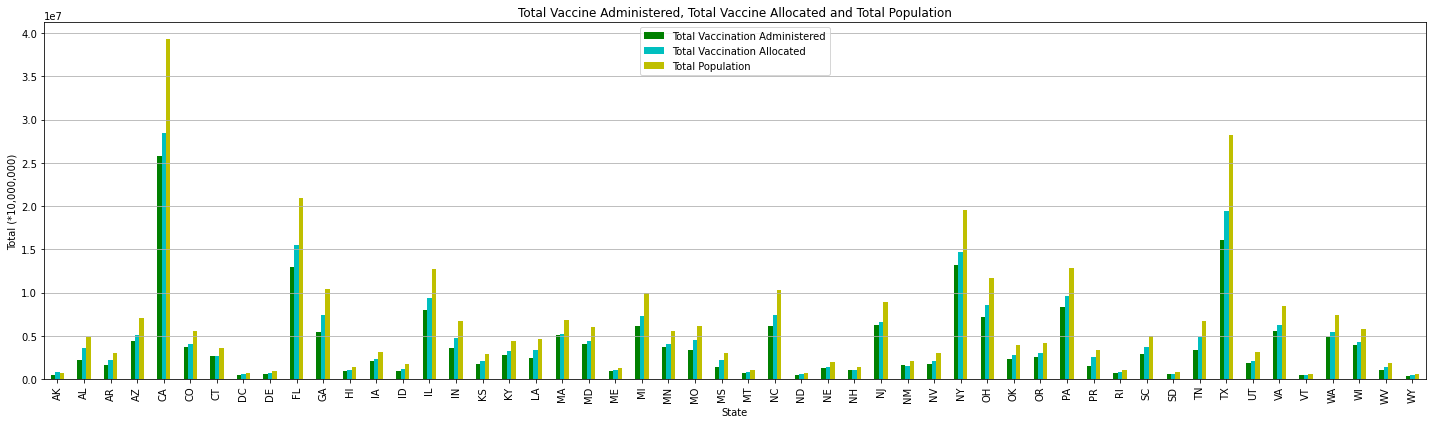

In [83]:
## Plot Line Chart

## Plot Figure

df_for_chart = merge_alloc_admin_census_df[['state_code',  'daily_vaccinations', 'Total Allocated',  'population']]
df_for_chart1 = df_for_chart.set_index('state_code')
df_chart_total = df_for_chart1.plot(kind='bar', figsize=(20,6), color={'daily_vaccinations': 'g', 'Total Allocated': 'c', 'population': 'y'}, stacked=False)

## Change Labels
df_chart_total.set_yticks(np.arange(0, max(df_for_chart['population'])+717000, 5000000))
df_chart_total.set_xlabel('State')
df_chart_total.set_ylabel('Total (*10,000,000)')
df_chart_total.set_title('Total Vaccine Administered, Total Vaccine Allocated and Total Population')
df_chart_total.legend(['Total Vaccination Administered', 'Total Vaccination Allocated', 'Total Population'], loc = 'upper center')

plt.tight_layout()
plt.grid(axis='y')

### Show and Export chart
plt.savefig("Graphs/Bar_Total_vaccines_Population.png", facecolor='w')
plt.show()

## Chart showing the % of Total Allocate Vaccines by CDS Vs % of Dose Administered by State (% calculated by dividing the Total Allocated and daily Vaccines by Each States Total Population)  
x-axis = State  
y-axis =   
1. Total Vaccines Allocated   
2. Total Vaccine Administered  

The data for Vaccine Adminstered not separated by state between 12/14/2020 to 1/13/2021

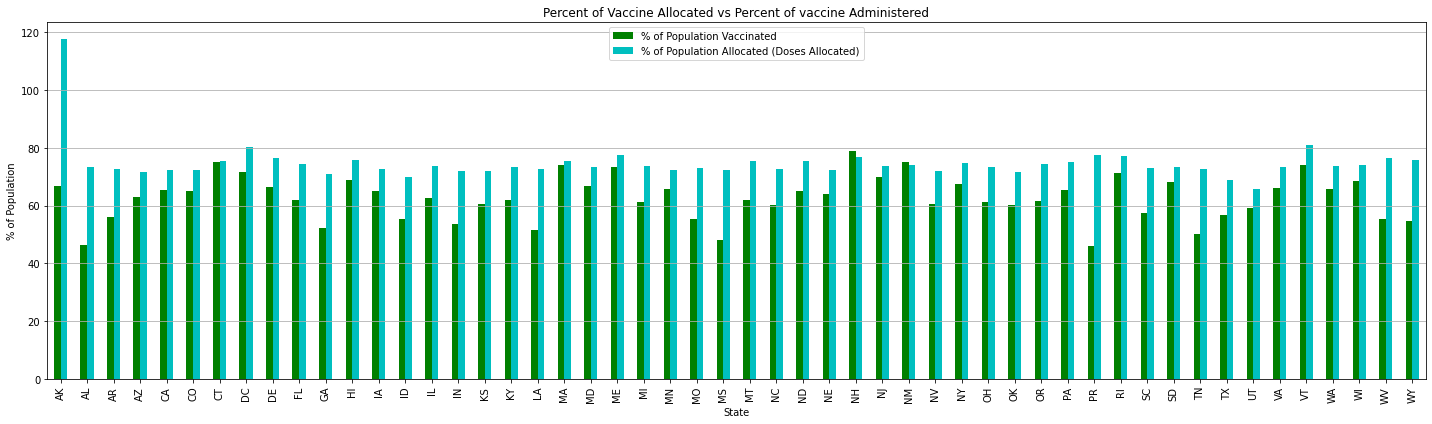

In [84]:
## States need to increase there vaccination rate

merge_alloc_admin_census_df['per_allocate'] = merge_alloc_admin_census_df['Total Allocated'] / merge_alloc_admin_census_df['population'] * 100
merge_alloc_admin_census_df['per_vaccinated'] = merge_alloc_admin_census_df['daily_vaccinations'] / merge_alloc_admin_census_df['population'] * 100
merge_alloc_admin_census_df.head()

### Create Dataframe
df_for_chart_per = merge_alloc_admin_census_df[['state_code', 'per_vaccinated', 'per_allocate']]

## Plot Graph
df_for_chart_per1 = df_for_chart_per.set_index('state_code')
df_chart_per = df_for_chart_per1.plot(kind='bar', figsize=(20,6), color={'per_vaccinated': 'g', 'per_allocate': 'c'}, stacked=False)


## Set Labels
df_chart_per.set_xlabel('State')
df_chart_per.set_ylabel('% of Population')
df_chart_per.set_title('Percent of Vaccine Allocated vs Percent of vaccine Administered')
df_chart_per.legend(['% of Population Vaccinated', '% of Population Allocated (Doses Allocated)'], loc='upper center')

## Show Graph
plt.tight_layout()
plt.grid(axis='y')
plt.savefig("Graphs/Bar_Percent_of_Population.png", facecolor='w')
plt.show()

In [85]:
total_pop_vac = merge_alloc_admin_census_df[['daily_vaccinations', 'Total Allocated',  'population']]
total_sum_pop_vac = total_pop_vac.sum()
print(total_sum_pop_vac)

per_pop_vac = total_sum_pop_vac['daily_vaccinations'] / total_sum_pop_vac['population'] * 100
print(f'{round(per_pop_vac, 4)}% of population has received atleast one dose')

daily_vaccinations    203708004.0
Total Allocated       239699150.0
population            328016242.0
dtype: float64
62.103% of population has received atleast one dose


# Group 2 Analysis - by Anne Niemiec

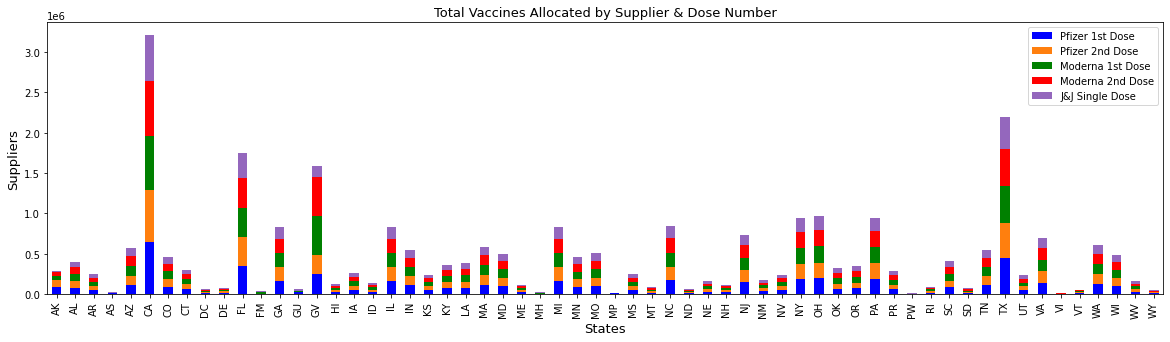

In [86]:
### Group 2 Charts authored by Anne Niemiec

#Fig1: Stacked Bar Plot showing Vaccine Allocations by State on latest date present in the data

# * x-axis = State

# * y-axis = 
#     * Bar 1: Pfizer cumulative 1st dose allocation
#     * Bar 2: Pfizer cumulative 2nd dose allocation
#     * Bar 3: Moderna cumulative 1st dose allocation
#     * Bar 4: Moderna cumulative 2nd dose allocation
#     * Bar 5: Johnson & Johnson cumulative single dose allocation

# rename dataframe and groupby specific columns
state_code_df=vaccine_allocation_df.groupby(["state_code"]).max()
state_code_wo_day_num=state_code_df[["pfe_dose_1","pfe_dose_2","mrna_dose_1","mrna_dose_2","jnj_dose_1"]]

# plotting
state_code_wo_day_num.plot(kind='bar', figsize=(20,5),stacked=True, color=['b', 'tab:orange', 'g', 'r', 'tab:purple'])

# formatting labels, title, legend
plt.title("Total Vaccines Allocated by Supplier & Dose Number",fontsize=13)
plt.xlabel("States", fontsize=13)
plt.ylabel("Suppliers",fontsize=13)
legend=plt.legend()
legend.get_texts()[0].set_text('Pfizer 1st Dose')
legend.get_texts()[1].set_text('Pfizer 2nd Dose')
legend.get_texts()[2].set_text('Moderna 1st Dose')
legend.get_texts()[3].set_text('Moderna 2nd Dose')
legend.get_texts()[4].set_text('J&J Single Dose')


plt.savefig("Graphs/allocations_state.png",facecolor='w')
plt.show()

Commentary: In this figure, the states are NOT normalized by population, therefore, it reflects a higher number of allocation for states including CA, FL, TX) that have a high population value.

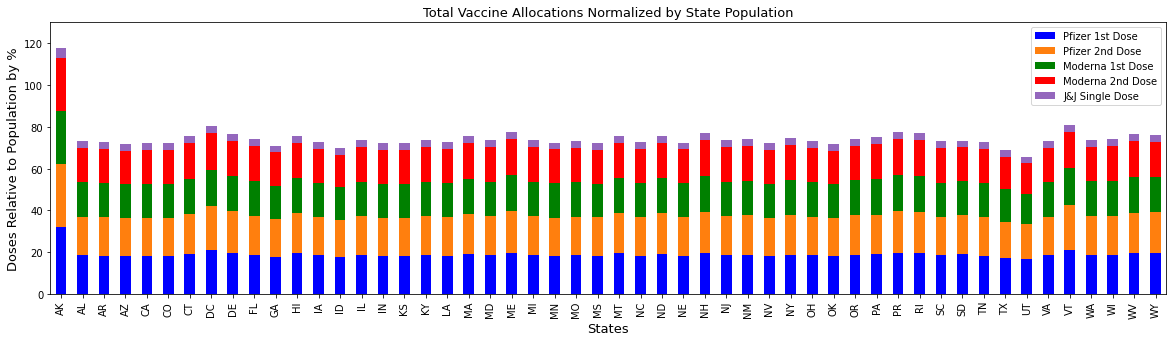

In [87]:
# Fig2: Stacked Bar Plot showing Vaccine Allocations Normalized by State Population by State on latest date present in the data

# * x-axis = State

# * y-axis = 
#     * Bar 1: Pfizer cumulative 1st dose allocation / State Population
#     * Bar 2: Pfizer cumulative 2nd dose allocation / State Population
#     * Bar 3: Moderna cumulative 1st dose allocation / State Population
#     * Bar 4: Moderna cumulative 2nd dose allocation / State Population
#     * Bar 5: Johnson & Johnson cumulative single dose allocation / State Population 

# merging datasets
state_sum=vaccine_allocation_df.groupby(["state_code"]).sum().reset_index()
combined_max_date=state_sum.merge(census_df, on='state_code',how='inner')

# columns to reference
combined_max_date["pfe_dose_1"]=100*(combined_max_date["pfe_dose_1"]/combined_max_date["population"])
combined_max_date["pfe_dose_2"]=100*(combined_max_date["pfe_dose_2"]/combined_max_date["population"])
combined_max_date["mrna_dose_1"]=100*(combined_max_date["mrna_dose_1"]/combined_max_date["population"])
combined_max_date["mrna_dose_2"]=100*(combined_max_date["mrna_dose_2"]/combined_max_date["population"])
combined_max_date["jnj_dose_1"]=100*(combined_max_date["jnj_dose_1"]/combined_max_date["population"])

# # plotting
combined_max_date=combined_max_date.set_index("state_code")
combined_max_date[["pfe_dose_1","pfe_dose_2","mrna_dose_1","mrna_dose_2","jnj_dose_1"]].plot(kind='bar', figsize=(20,5),stacked=True,ylim=(0,130),color=['b', 'tab:orange', 'g', 'r', 'tab:purple'])

# formatting labels, title, legend
plt.title("Total Vaccine Allocations Normalized by State Population",fontsize=13)
plt.xlabel("States", fontsize=13)
plt.ylabel("Doses Relative to Population by %",fontsize=13)
legend=plt.legend()
legend.get_texts()[0].set_text('Pfizer 1st Dose')
legend.get_texts()[1].set_text('Pfizer 2nd Dose')
legend.get_texts()[2].set_text('Moderna 1st Dose')
legend.get_texts()[3].set_text('Moderna 2nd Dose')
legend.get_texts()[4].set_text('J&J Single Dose')

plt.savefig("Graphs/normalized_population.png",facecolor='w')
plt.show()

Commentary:  Whereas in this figure, once the population value is normalized, it portrays a more even allocation for all states with the exception of Utah and Alaska by percentage.    We believe the reasoning is based on X.  If the goal is to achieve vaccination for the entire population, the % value in the chart would equate to x%. The values are similar/same for Pfizer since the doses are automatically scheduled for you.  Maderna has fewer shots (doses 1 & 2) than Pfizer (doses 1 & 2).  Q:(1/3 should receive Pfizer, 1/3 Moderna, 1/3 J&J)

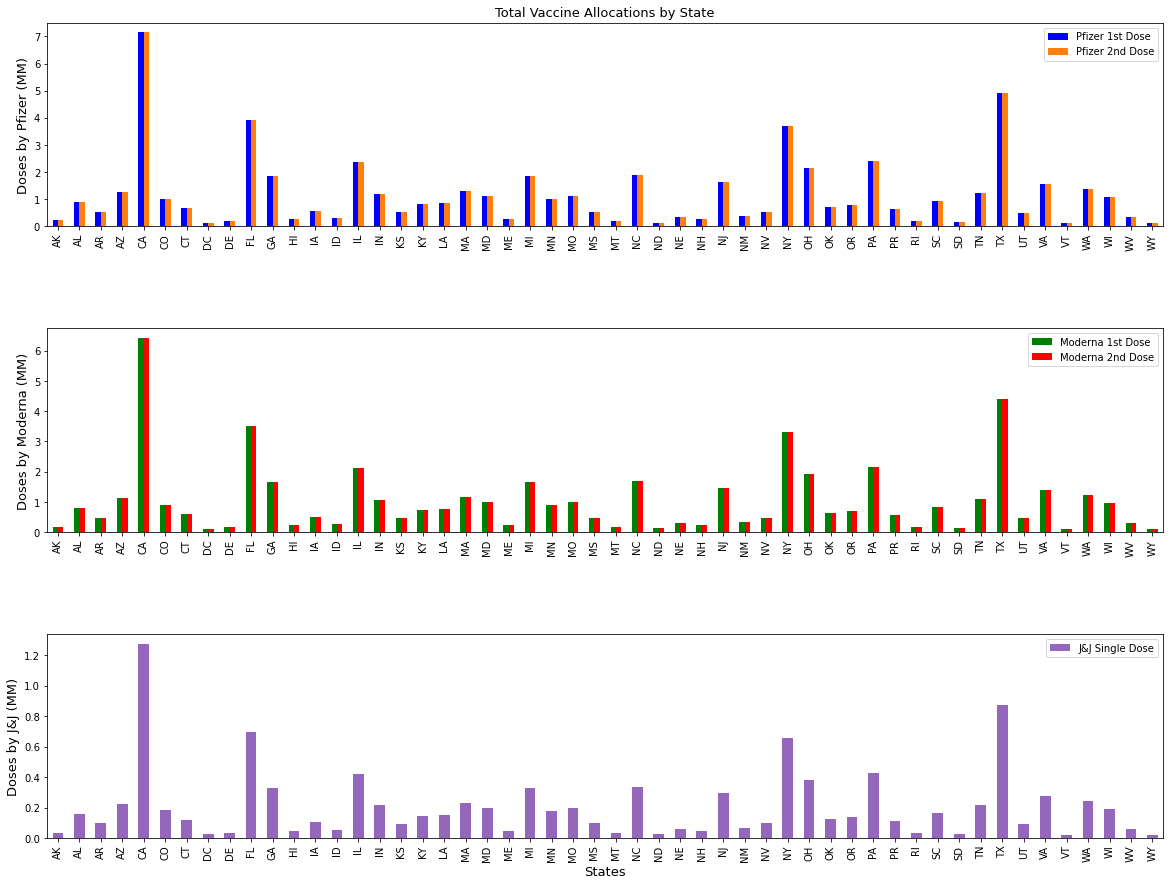

In [88]:
# Fig3: plot figure of Stacked Bar Plots showing Vaccine Allocations by State on latest date present in the data

# * x-axis = State
#     * Note, this is common to all 3 figures and should only be displayed on the bottom figure.

# * Plot 1, y-axis:
#     * Bar 1: Pfizer cumulative 1st dose allocation
#     * Bar 2: Pfizer cumulative 2nd dose allocation
# * Plot 2, y-axis:
#     * Bar 1: Moderna cumulative 1st dose allocation
#     * Bar 2: Moderna cumulative 2nd dose allocation
# * Plot 3, y-axis:
#     * Bar: Johnson & Johnson cumulative single dose allocation

# * Example implementation: https://matplotlib.org/2.0.2/examples/ticks_and_spines/spines_demo.html

# merging datasets
allocation_by_state_df=vaccine_allocation_df.merge(census_df, on='state_code',how='inner')
last_date_df=allocation_by_state_df.groupby(["state_code"]).sum().reset_index()
state_last_date=last_date_df[["state_code", "day_num"]].merge(last_date_df,on=["state_code", "day_num"],how='left')

# adjusting values
state_last_date["pfe_dose_1"]=state_last_date["pfe_dose_1"]/1000000
state_last_date["pfe_dose_2"]=state_last_date["pfe_dose_2"]/1000000
state_last_date["mrna_dose_1"]=state_last_date["mrna_dose_1"]/1000000
state_last_date["mrna_dose_2"]=state_last_date["mrna_dose_2"]/1000000
state_last_date["jnj_dose_1"]=state_last_date["jnj_dose_1"]/1000000

# # plotting (1,2,3)
state_last_date=state_last_date.set_index("state_code")
fig, axes = plt.subplots(nrows=3)
fig1=state_last_date[["pfe_dose_1","pfe_dose_2"]].plot(ax=axes[0],kind='bar', figsize=(20,15),color={'pfe_dose_1': 'b', 'pfe_dose_2':'tab:orange'})
fig2=state_last_date[["mrna_dose_1","mrna_dose_2"]].plot(ax=axes[1],kind='bar',color={'mrna_dose_1': 'g', 'mrna_dose_2':'r'},figsize=(20,15))
fig3=state_last_date[["jnj_dose_1"]].plot(ax=axes[2],kind='bar',color="tab:purple",figsize=(20,15))

# formatting labels, title
fig1.set_title("Total Vaccine Allocations by State",fontsize=13)
fig3.set_xlabel("States", fontsize=13)
fig1.set_ylabel("Doses by Pfizer (MM)",fontsize=13)
fig2.set_ylabel("Doses by Moderna (MM)",fontsize=13)
fig3.set_ylabel("Doses by J&J (MM)",fontsize=13)
fig1.set_xlabel("")
fig2.set_xlabel("")
legend=plt.legend()

#formatting legends
fig1.legend(["Pfizer 1st Dose", "Pfizer 2nd Dose"])
# plt.savefig("cummulative_allocations_state_1.png")
fig2.legend(["Moderna 1st Dose", "Moderna 2nd Dose"])
# plt.savefig("cummulative_allocations_state_2.png")
fig3.legend(["J&J Single Dose"])

plt.subplots_adjust(hspace=0.5)
plt.savefig("Graphs/cummulative_allocations_state.png",facecolor='w')
plt.show()

Commentary: Note, these images contain the number of total vaccines allocated by state. In figures 1 & 2, you will notice the bars mirror each other due to the fact that the patient is automatically scheduled for the 2nd dose (Pfizer & Moderna) at the time of receiving their first dose; hence the allocation for dose two is the same value as dose one. In the third figure, you only see one bar, since J&J is a single dose vaccine. However, it appears that CA has received a higher number of doses of moderna versus Pfizer and J&J.

# Group 3 Analysis - by Nicole Lund

#### Line Plot showing Cumulative National Vaccine Allocations and Reported deaths by date

* x-axis = Date

* Left y-axis = Total vaccine doses allocated cumulative across states
    * Note, reported weekly 

* Right y-axis = New deaths reported cumulative across states
    * Note, reported daily

* Example report with separate plots: https://www.cnbc.com/2021/04/09/covid-19-cases-deaths-vaccinations-daily-update.html

In [89]:
# Collect summary data
distribution_totals_s = vaccine_allocation_df.groupby(['day_num']).sum().sum(axis=1).cumsum()
# print(distribution_totals_s.head(3))

us_vaccination_totals_s = vaccine_admin_df.groupby(['day_num']).sum().cumsum()
# print(us_vaccination_totals_s.head(3))

us_cases_deaths_df = cases_deaths_df.groupby(['day_num']).sum()
# print(us_cases_deaths_df.head(3))

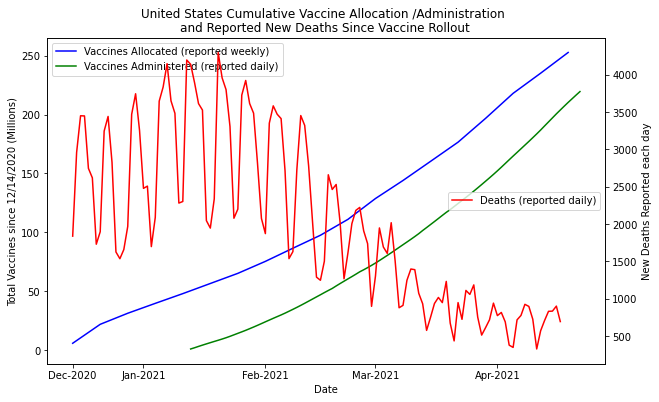

In [90]:
# Plot the data
fig_3a = plt.figure(figsize=(10,6))

# Plot on left axis
ax_3a_L = fig_3a.subplots()

ax_3a_L.plot(distribution_totals_s.index,distribution_totals_s.values/1000000,c='b')
ax_3a_L.plot(us_vaccination_totals_s.index,us_vaccination_totals_s.values/1000000,c='g')

ax_3a_L.set_ylabel('Total Vaccines since 12/14/2020 (Millions)')
ax_3a_L.legend(['Vaccines Allocated (reported weekly)','Vaccines Administered (reported daily)'],loc='upper left')

# Plot on left axis
ax_3a_R = ax_3a_L.twinx()

ax_3a_R.plot(us_cases_deaths_df.index,us_cases_deaths_df['new_deaths'],c='r')

ax_3a_R.set_ylabel('New Deaths Reported each day')
ax_3a_R.legend(['Deaths (reported daily)'],loc='center right')

# Annotate plot
ax_3a_R.set_title('United States Cumulative Vaccine Allocation /Administration  \nand Reported New Deaths Since Vaccine Rollout ')
ax_3a_L.set_xlabel('Date')
plt.xticks([0, 18, 49, 77, 108], ['Dec-2020', 'Jan-2021', 'Feb-2021', 'Mar-2021', 'Apr-2021'], rotation='horizontal')

plt.savefig("Graphs/US_vac_alloc_admin_deaths_daily.png",facecolor='w')

plt.show()

#### Line Plot showing Cumulative National Vaccine Allocations and Reported deaths by week

* x-axis = Date (weekly on Mondays)

* Left y-axis = Total vaccine doses allocated cumulative across states

* Right y-axis = New deaths reported cumulative across states

In [91]:
# Collect collect death data into weekly totals
day_num_daily = us_cases_deaths_df.index.tolist()
new_deaths_daily = us_cases_deaths_df['new_deaths'].tolist()

day_num_weekly = []
new_deaths_weekly = []
death_sum = 0
for day, deaths in zip(day_num_daily,new_deaths_daily):
    if day in distribution_totals_s.index:
        day_num_weekly.append(day)
        new_deaths_weekly.append(death_sum)
        death_sum = deaths
    else:
        death_sum += deaths

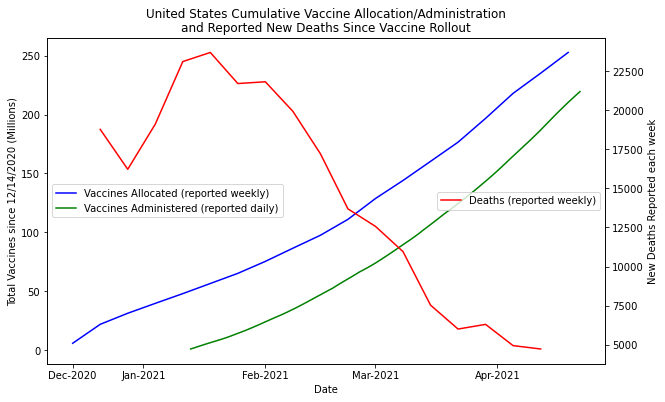

In [92]:
# Plot the data
fig_3b = plt.figure(figsize=(10,6))

# Plot on left axis
ax_3b_L = fig_3b.subplots()

ax_3b_L.plot(distribution_totals_s.index,distribution_totals_s.values/1000000,c='b')
ax_3b_L.plot(us_vaccination_totals_s.index,us_vaccination_totals_s.values/1000000,c='g')

ax_3b_L.set_ylabel('Total Vaccines since 12/14/2020 (Millions)')
ax_3b_L.legend(['Vaccines Allocated (reported weekly)','Vaccines Administered (reported daily)'],loc='center left')

# Plot on left axis
ax_3b_R = ax_3b_L.twinx()

ax_3b_R.plot(day_num_weekly[1:],new_deaths_weekly[1:],c='r')

ax_3b_R.set_ylabel('New Deaths Reported each week')
ax_3b_R.legend(['Deaths (reported weekly)'],loc='center right')

# Annotate plot
ax_3b_L.set_xlabel('Date')
ax_3b_L.set_title('United States Cumulative Vaccine Allocation/Administration\nand Reported New Deaths Since Vaccine Rollout')
plt.xticks([0, 18, 49, 77, 108], ['Dec-2020', 'Jan-2021', 'Feb-2021', 'Mar-2021', 'Apr-2021'], rotation='horizontal')

plt.savefig("Graphs/US_vac_alloc_admin_deaths_weekly.png",facecolor='w')
plt.show()

#### Line Plot showing Cumulative National Vaccine Regimens and Reported deaths by date

* x-axis = Date (weekly on Mondays)

* Left y-axis = Total vaccine regimens allocated
    * Note, cumulative across states

* Right y-axis = New deaths reported weekly

This plot did not add any useful information

In [93]:
# Collect summary data for full treatment regimens 
distribution_totals_df = vaccine_allocation_df.groupby(['day_num']).sum()

pfe_regimens = distribution_totals_df[['pfe_dose_1','pfe_dose_2']].sum(axis=1)/2
mrna_regimens = distribution_totals_df[['mrna_dose_1','mrna_dose_2']].sum(axis=1)/2
jnj_regimens = distribution_totals_df[['jnj_dose_1']]

total_regimens = pd.concat([pfe_regimens,mrna_regimens,jnj_regimens],axis=1).sum(axis=1).cumsum()
total_regimens.head(3)

day_num
0      2962050.0
7     11003225.0
14    15693750.0
dtype: float64

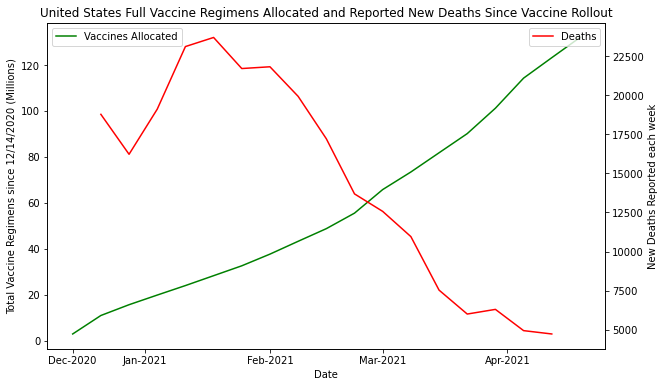

In [94]:
# Plot the data
fig_3c = plt.figure(figsize=(10,6))

# Plot left axis
fig_3c_L = fig_3c.subplots()

fig_3c_L.plot(total_regimens.index,total_regimens.values/1000000,c='g')

fig_3c_L.set_ylabel('Total Vaccine Regimens since 12/14/2020 (Millions)')

fig_3c_L.set_xlabel('Date')

fig_3c_L.set_title('United States Full Vaccine Regimens Allocated and Reported New Deaths Since Vaccine Rollout')

fig_3c_L.legend(['Vaccines Allocated'],loc='upper left')

# Plot right axis
fig_3c_R = fig_3c_L.twinx()
fig_3c_R.plot(day_num_weekly[1:],new_deaths_weekly[1:],c='r')
fig_3c_R.set_ylabel('New Deaths Reported each week')
plt.legend(['Deaths'],loc='upper right')

plt.xticks([0, 18, 49, 77, 108], ['Dec-2020', 'Jan-2021', 'Feb-2021', 'Mar-2021', 'Apr-2021'], rotation='horizontal')

plt.savefig("Graphs/US_regimens_alloc_deaths_weekly.png",facecolor='w')
plt.show()

#### Scatter Plot showing Reported Covid-19 Case Rate vs Poverty Rate by State

* x-axis = Poverty Rate (Percentage)

* y-axis = Reported Covid-19 Case Count / Population (Percentage)

* Include regression analysis

In [95]:
# Collect summary data of last reported data
last_cases_deaths_df = cases_deaths_df.loc[cases_deaths_df.groupby('state_name').day_num.idxmax()]
reported_cases_deaths_df = last_cases_deaths_df.groupby('state_code').sum()

cases_poverty_df = census_df.merge(reported_cases_deaths_df,on='state_code',how='left')
cases_poverty_df['case_rate'] = 100*cases_poverty_df['total_cases']/cases_poverty_df['population']
cases_poverty_df['death_rate'] = 100*cases_poverty_df['total_deaths']/cases_poverty_df['population']
cases_poverty_df.head(3)

,state_name,state_code,population,median_age,household_income,per_capita_income,poverty_count,poverty_rate,unemployment_count,unemployment_rate,...,probable_cases,new_cases,pnew_cases,total_deaths,confirmed_deaths,probable_deaths,new_deaths,pnew_deaths,case_rate,death_rate
0,Alabama,AL,4876250.0,39.0,50536.0,27928.0,795989.0,16.323794,132095.0,2.708946,...,116939.0,508,208.0,10790,8498.0,2292.0,51,9.0,10.707634,0.221277
1,Alaska,AK,737068.0,34.3,77640.0,36787.0,76933.0,10.437707,26808.0,3.637114,...,0.0,0,0.0,329,0.0,0.0,0,0.0,8.580619,0.044636
2,Arizona,AZ,7050299.0,37.7,58945.0,30694.0,1043764.0,14.804535,195905.0,2.778676,...,61524.0,480,114.0,17151,15229.0,1922.0,-2,-9.0,12.099487,0.243266


In [96]:
# Restrict to states only: remove DC, PR
state_cases_poverty_df = cases_poverty_df.loc[
    (cases_poverty_df['state_code'] != "DC") &
    (cases_poverty_df['state_code'] != "PR")]
state_cases_poverty_df.head(3)

,state_name,state_code,population,median_age,household_income,per_capita_income,poverty_count,poverty_rate,unemployment_count,unemployment_rate,...,probable_cases,new_cases,pnew_cases,total_deaths,confirmed_deaths,probable_deaths,new_deaths,pnew_deaths,case_rate,death_rate
0,Alabama,AL,4876250.0,39.0,50536.0,27928.0,795989.0,16.323794,132095.0,2.708946,...,116939.0,508,208.0,10790,8498.0,2292.0,51,9.0,10.707634,0.221277
1,Alaska,AK,737068.0,34.3,77640.0,36787.0,76933.0,10.437707,26808.0,3.637114,...,0.0,0,0.0,329,0.0,0.0,0,0.0,8.580619,0.044636
2,Arizona,AZ,7050299.0,37.7,58945.0,30694.0,1043764.0,14.804535,195905.0,2.778676,...,61524.0,480,114.0,17151,15229.0,1922.0,-2,-9.0,12.099487,0.243266


In [97]:
# Regression analysis
(slope, intercept, rvalue, pvalue, stderr) = linregress(state_cases_poverty_df.poverty_rate,state_cases_poverty_df.case_rate)
y_regress = state_cases_poverty_df.poverty_rate * slope + intercept
line_text = f"y={str(round(slope,2))}x + {str(round(intercept,2))}, r-value is: {str(round(rvalue ** 2,4))}"

The r-value is: 0.057277908299769933


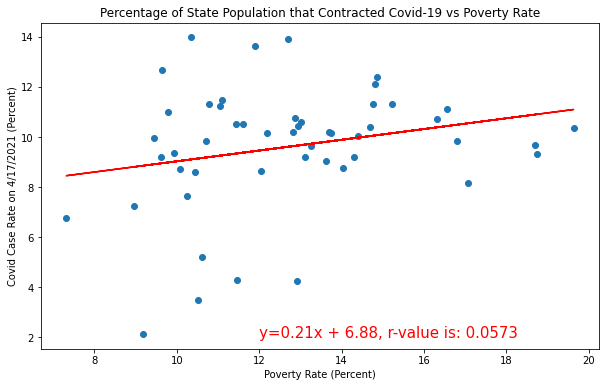

In [98]:
print(f"The r-value is: {rvalue ** 2}")

# Plot the data
fig_3d = plt.figure(figsize=(10,6))
ax_3d = fig_3d.subplots()

# Scatter plot
ax_3d.scatter(state_cases_poverty_df.poverty_rate,state_cases_poverty_df.case_rate)

# Regression line
ax_3d.plot(state_cases_poverty_df.poverty_rate,y_regress,"r-")
ax_3d.annotate(line_text,(12,2),fontsize=15,color="red")

# Annotate plot
ax_3d.set_xlabel('Poverty Rate (Percent)')
ax_3d.set_ylabel('Covid Case Rate on 4/17/2021 (Percent)')
ax_3d.set_title('Percentage of State Population that Contracted Covid-19 vs Poverty Rate')

plt.savefig("Graphs/state_cases_poverty.png",facecolor='w')
plt.show()

#### Scatter Plot showing Reported Covid-19 Death Rate vs Poverty Rate by State

* x-axis = Poverty Rate (Percentage)

* y-axis = Reported Covid-19 Death Count / Population (Percentage)

* Include regression analysis

In [99]:
# Regression analysis
(slope2, intercept2, rvalue2, pvalue2, stderr2) = linregress(state_cases_poverty_df.poverty_rate,state_cases_poverty_df.death_rate)
y_regress2 = state_cases_poverty_df.poverty_rate * slope2 + intercept2
line_text2 = f"y={str(round(slope2,2))}x + {str(round(intercept2,2))}, r-value is: {str(round(rvalue2 ** 2,4))}"

The r-value is: 0.1527784830609351


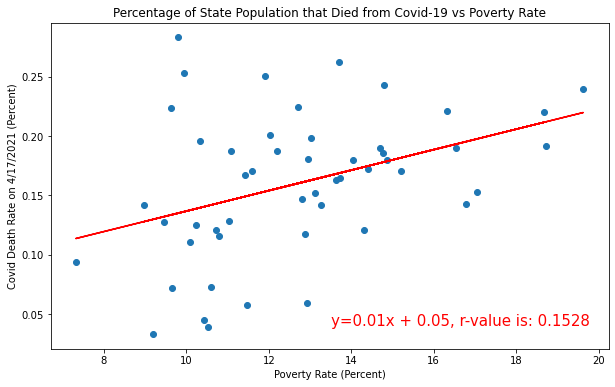

In [100]:
print(f"The r-value is: {rvalue2 ** 2}")

# Plot the data
fig_3e = plt.figure(figsize=(10,6))
ax_3e = fig_3e.subplots()

# Scatter plot
ax_3e.scatter(state_cases_poverty_df.poverty_rate,state_cases_poverty_df.death_rate)

# Regression line
ax_3e.plot(state_cases_poverty_df.poverty_rate,y_regress2,"r-")
ax_3e.annotate(line_text2,(13.5,0.04),fontsize=15,color="red")

# Annotate plot
ax_3e.set_xlabel('Poverty Rate (Percent)')
ax_3e.set_ylabel('Covid Death Rate on 4/17/2021 (Percent)')
ax_3e.set_title('Percentage of State Population that Died from Covid-19 vs Poverty Rate')

plt.savefig("Graphs/state_deaths_poverty.png",facecolor='w')
plt.show()

#### Line Plot showing Cumulative Arizona Vaccine Allocations and Reported deaths by week

* x-axis = Date (weekly on Mondays)

* Left y-axis = Total vaccine doses allocated to Arizona

* Right y-axis = New deaths reported in Arizona

In [101]:
# Collect summary data
az_vaccine_allocation_df = vaccine_allocation_df.loc[vaccine_allocation_df['state_code'] == 'AZ']
az_distribution_totals_s = az_vaccine_allocation_df.groupby(['day_num']).sum().sum(axis=1).cumsum()
# print(az_distribution_totals_s.head(3))

az_vaccine_admin_df = vaccine_admin_df.loc[vaccine_admin_df['state_code'] == 'AZ']
az_vaccination_totals_s = az_vaccine_admin_df.groupby(['day_num']).sum().cumsum()
# print(az_vaccination_totals_s.head(3))

azonly_cases_deaths_df = cases_deaths_df.loc[cases_deaths_df['state_code'] == 'AZ']
az_cases_deaths_df = azonly_cases_deaths_df.groupby(['day_num']).sum()
# print(az_cases_deaths_df.new_deaths)

In [102]:
# Collect collect death data into weekly totals
az_day_num_daily = az_cases_deaths_df.index.tolist()
az_new_deaths_daily = az_cases_deaths_df['new_deaths'].tolist()
# print(az_day_num_daily, az_new_deaths_daily)

az_day_num_weekly = []
az_new_deaths_weekly = []
az_death_sum = 0
for day, deaths in zip(az_day_num_daily,az_new_deaths_daily):
    if day in az_distribution_totals_s.index:
        az_day_num_weekly.append(day)
        az_new_deaths_weekly.append(az_death_sum)
        az_death_sum = deaths
        # print(az_death_sum)
    else:
        az_death_sum += deaths
        # print(az_death_sum)

# print(az_day_num_weekly, az_new_deaths_weekly)

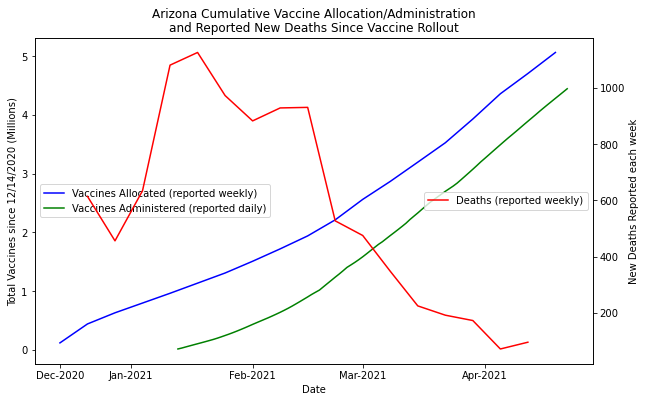

In [103]:
# Plot the data
fig_3f = plt.figure(figsize=(10,6))

# Plot on left axis
ax_3f_L = fig_3f.subplots()

ax_3f_L.plot(az_distribution_totals_s.index,az_distribution_totals_s.values/1000000,c='b')
ax_3f_L.plot(az_vaccination_totals_s.index,az_vaccination_totals_s.values/1000000,c='g')

ax_3f_L.set_ylabel('Total Vaccines since 12/14/2020 (Millions)')
ax_3f_L.legend(['Vaccines Allocated (reported weekly)','Vaccines Administered (reported daily)'],loc='center left')

# Plot on left axis
ax_3f_R = ax_3f_L.twinx()

ax_3f_R.plot(az_day_num_weekly[1:],az_new_deaths_weekly[1:],c='r')

ax_3f_R.set_ylabel('New Deaths Reported each week')
ax_3f_R.legend(['Deaths (reported weekly)'],loc='center right')

# Annotate plot
ax_3f_L.set_xlabel('Date')
ax_3f_L.set_title('Arizona Cumulative Vaccine Allocation/Administration\nand Reported New Deaths Since Vaccine Rollout')
plt.xticks([0, 18, 49, 77, 108], ['Dec-2020', 'Jan-2021', 'Feb-2021', 'Mar-2021', 'Apr-2021'], rotation='horizontal')

plt.savefig("Graphs/AZ_vac_alloc_admin_deaths_weekly.png",facecolor='w')
plt.show()